In [1]:
"""
All necessary imports
"""

import math
import csv

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.spatial.distance as distance
import scipy

from pandas import read_csv
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from minepy import MINE

import matplotlib.pyplot as plt
import seaborn
from mrmr import mrmr_classif
import pprint
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

from mendeleev import element
from mendeleev.fetch import fetch_table
import pandas as pd
import time
import ast
import re

In [2]:
converters = {
    'elem_in_site_order': ast.literal_eval,
    'elem_by_formula_order': ast.literal_eval,
    'num_electrons': ast.literal_eval,
    'eaffinity': ast.literal_eval,
    'dipole': ast.literal_eval,
    'covalent_rad': ast.literal_eval,
    'atomic_vol': ast.literal_eval,
    'atomic_rad': ast.literal_eval,
    'A1': ast.literal_eval,  # Converter for column 'A1'
    'A2': ast.literal_eval,  # Converter for column 'A2'
    'B1': ast.literal_eval,  # Converter for column 'B1'
    'B2': ast.literal_eval,  # Converter for column 'B2'
    'X': ast.literal_eval,   # Converter for column 'X'
}

df2 = pd.read_csv('maxrad.csv', converters=converters)


In [3]:
pd.set_option('display.max_columns', None)
df = df2
#display(df.head(1))

#print(df['A1'])
print(type(df.head(1)['A1']))
print(df.head(1)['A1'][0]['atomic_rad'])

#remove 21 faulty materials
df = df[df['X'] != {}]
#display(df.iloc[55:66])

print(df['atomic_rad'].head(3))

<class 'pandas.core.series.Series'>
130.0
0    [130.0, 125.0, 137.0, 160.0, 128.0]
1           [130.0, 125.0, 137.0, 160.0]
2    [130.0, 125.0, 132.0, 137.0, 160.0]
Name: atomic_rad, dtype: object


In [4]:
"""
this code adds max S,P,D values to each entry in the data set, but it can be modified to add other things like num unpaired electrons later
"""



# #add S,P,D rmax to the sites



# dfrads = pd.read_csv('Rad_expectations.csv')
# print(dfrads)

# descripts = ['atomic_rad', 'atomic_vol', 'covalent_rad', 'dipole', 'eaffinity', 'num_electrons' ]

# sites = ['A1', 'A2', 'B1', 'B2', 'X']
# for(index, row) in df.iterrows():
#     lms = row['elem_in_site_order']
#     print(lms)
#     for i in range(len(lms)):
#         cur_site = sites[i]
#         tmpdct = row[cur_site] 
#         cur_element = lms[i]
#         #find the right element:
#         cur_ind = 0
#         for (ind2, row2) in dfrads.iterrows():
#             if row2['element']==cur_element:
#                 cur_ind = ind2
#         tmpdct['maxS'] = dfrads.iloc[cur_ind]['max S']
#         tmpdct['maxP'] = dfrads.iloc[cur_ind]['max P']
#         tmpdct['maxD'] = dfrads.iloc[cur_ind]['max D']
#         df.at[index, sites[i]] = tmpdct
        
# df.to_csv('maxrad.csv', index=False)

# #add num unpaired electrons to sites, now adding valence electron num (can swap whatever csv and feature you want at this point)



# dfnups = pd.read_csv('nval.csv')
# # print(dfnups)

# #descripts = ['atomic_rad', 'atomic_vol', 'covalent_rad', 'dipole', 'eaffinity', 'num_electrons' ]

# sites = ['A1', 'A2', 'B1', 'B2', 'X']
# for(index, row) in df.iterrows():
#     lms = row['elem_in_site_order']
#     print(lms)
#     for i in range(len(lms)):
#         cur_site = sites[i]
#         tmpdct = row[cur_site] 
#         cur_element = lms[i]
#         #find the right element:
#         cur_ind = 0
#         for (ind2, row2) in dfnups.iterrows():
#             if row2['element']==cur_element:
#                 cur_ind = ind2
#         tmpdct['n_val_single'] = dfnups.iloc[cur_ind]['nval']
#         df.at[index, sites[i]] = tmpdct
        
# df.to_csv('maxrad.csv', index=False)

'\nthis code adds max S,P,D values to each entry in the data set, but it can be modified to add other things like num unpaired electrons later\n'

In [5]:
"""
manually compute and use standardscaler
"""


#add 1.0 properties###########################################
properties = ['atomic_rad', 'atomic_vol','dipole', 'eaffinity','covalent_rad', 'num_electrons']
sums = {}
tot_n = 0
for i in properties:
    cursum = 0
    num_data = 0
    for(index, row) in df.iterrows():  
        for j in row[i]:
            cursum+=j
            num_data+=1
    sums[i]= cursum
    tot_n = num_data
###########################################



#add maxSPD and nup###########################################
spdProps = ['maxS', 'maxP', 'maxD', 'n_up_single', 'n_val_single']
sites = ['A1', 'A2', 'B1', 'B2', 'X']
for i in spdProps:
    cursum = 0
    num_data = 0
    for(index, row) in df.iterrows(): 
        for j in sites:
            curcur = row[j][i]
            cursum+=curcur
            num_data +=1
     
    sums[i]= cursum
    tot_n = num_data
###########################################


averages = {}
for i in sums:
    averages[i] = sums[i] / tot_n
print("averages: ", averages)
#we have averages for each value, now pass through again to find std deviation

#1.0 stddevs###########################################
stddev = {}
for i in properties:
    square_diff_sum = 0
    for(index, row) in df.iterrows():  
        for j in row[i]:
            square_diff_sum += ((j-averages[i])**2)
    stddev[i] = math.sqrt( (square_diff_sum)/tot_n )
print("stddevs: ", stddev)
###########################################

#spd stddevs####################################
for i in spdProps:
    square_diff_sum = 0
    for(index, row) in df.iterrows():  
        for j in sites:
            square_diff_sum += ((row[j][i]-averages[i])**2)
    stddev[i] = math.sqrt( (square_diff_sum)/tot_n )
print("stddevs: ", stddev)
############################################

#now i have std deviation and mean for all properties, time to manually standard scaler
#scale the data stored in property order
for i in properties:
    for(index, row) in df.iterrows(): 
        curnew = [] 
        for j in row[i]:
            j = (j - averages[i])/stddev[i]
            curnew.append(j)

        df.at[index, i] = curnew
#display(df)

#now the property order is standard scaler'ed, time to do on site order

sites = ['A1', 'A2', 'B1', 'B2', 'X']
for i in sites:
    for(index, row) in df.iterrows(): 
        curnew = {} 
        for j in row[i]:
           #print(j)
            curnew[j] = (row[i][j] - averages[j])/stddev[j]
        #display(curnew)
        df.at[index, i] = curnew
#display(df['A1'])
       

averages:  {'atomic_rad': 130.4390243902439, 'atomic_vol': 12.255609756097536, 'dipole': 49.56606829268321, 'eaffinity': 1.0472338982829317, 'covalent_rad': 116.45463414634146, 'num_electrons': 33.33073170731707, 'maxS': 2.112599024390244, 'maxP': 1.8012468292682897, 'maxD': 1.8837980487804717, 'n_up_single': 2.5697560975609757, 'n_val_single': 5.098536585365854}
stddevs:  {'atomic_rad': 17.175269633168526, 'atomic_vol': 4.913615852383537, 'dipole': 25.0278338075077, 'eaffinity': 0.5548968979398397, 'covalent_rad': 14.288533070069413, 'num_electrons': 17.654129414190695}
stddevs:  {'atomic_rad': 17.175269633168526, 'atomic_vol': 4.913615852383537, 'dipole': 25.0278338075077, 'eaffinity': 0.5548968979398397, 'covalent_rad': 14.288533070069413, 'num_electrons': 17.654129414190695, 'maxS': 0.5626248485395698, 'maxP': 0.5948351889407196, 'maxD': 1.3483687312131079, 'n_up_single': 0.8388508045051414, 'n_val_single': 1.1807594930250813}


In [6]:
pd.set_option('display.max_colwidth', None)
def truncate_decimals(number):
    return round(number, 2)
print(df['atomic_rad'].apply(lambda x: [truncate_decimals(i) for i in x]).head(3))
pd.reset_option('display.max_colwidth')

0    [-0.03, -0.32, 0.38, 1.72, -0.14]
1           [-0.03, -0.32, 0.38, 1.72]
2     [-0.03, -0.32, 0.09, 0.38, 1.72]
Name: atomic_rad, dtype: object


In [7]:
'''for each element in elem site order:
    find the index in elem by formula order
    use this index to scrape each atom_rad till num electrons, then add them to a dict in that site

    for me: A1 (aka P1) will be atom radius, atom volume,
            A2 will be dipole polarizability, electron affinity
            A3 will be  covalent radius, num electrons

            
            
in order to read as floats and ints, I will store the method of finding the value as the label of the column

starting out will stick to A-A, A-X, B-X interactions

here are the calculations to see how many columns will be generated
NOTE: IDs from the paper are ABCDEF, since this will be confusing with A and B sites, I will call A and B ids P and Q now:
I am doing 2.5 times the calculations i think
P1:  Atom radius and Atom volume:
P2:  Dipole Polarizability, Electron affinity
P3:  covalent radius, num electrons

the paper is 4,4,6, so I have more features to start with. to prevent this from beign too large an issue I will start by only combining the following:


NOTE: the combinations in the paper are all combinations of two different sites (no A A or B B), with two different symbols to connect them (+ or -).
there are overlaps that are not included (A+B = B+A). this is how they are generated, it took an embarrasing amount of time to verify that

here are the interactions I will consider:

f(A1, A2), f(A2,A1) f(A1,X) f(A2,X) f(X,A1) f(X,A2) f(B1,X) f(B2,X) f(X,B1) f(X,B2)
there are + and - for all of them, which makes the total number for Q1 20, -5 for a1+a2=a2+a1 = 15 This is slightly higher than the 12 from the paper, but manageable

as an example, one of the Q1 descriptors is something like this:
ar = atom radius, av = atom volume

|ar(A1)+ar(A2)|



Q1: absolute differences and sums of P1 : 


this must be very modular, since I am creating order 10,000 columns. 

plan of action:
make list of the 10 interactions that I can loop through (f(A1, A2), f(A2,A1) f(A1,X) f(A2,X) f(X,A1) f(X,A2) f(B1,X) f(B2,X) f(X,B1) f(X,B2))

create a function that takes the two site names as arguments, finds their 2 interactions, and appends them to the respective columns (must compute column name)

calculate(A1, A2, abs_sumdiff, dataframe)

data stored like so:
column name = "P2+", "P2-"

inside column store dict of key value, where key is "ipA1" or "ipA1-ipA2"




'''

'for each element in elem site order:\n    find the index in elem by formula order\n    use this index to scrape each atom_rad till num electrons, then add them to a dict in that site\n\n    for me: A1 (aka P1) will be atom radius, atom volume,\n            A2 will be dipole polarizability, electron affinity\n            A3 will be  covalent radius, num electrons\n\n            \n            \nin order to read as floats and ints, I will store the method of finding the value as the label of the column\n\nstarting out will stick to A-A, A-X, B-X interactions\n\nhere are the calculations to see how many columns will be generated\nNOTE: IDs from the paper are ABCDEF, since this will be confusing with A and B sites, I will call A and B ids P and Q now:\nI am doing 2.5 times the calculations i think\nP1:  Atom radius and Atom volume:\nP2:  Dipole Polarizability, Electron affinity\nP3:  covalent radius, num electrons\n\nthe paper is 4,4,6, so I have more features to start with. to prevent thi

In [8]:
dsct = {
    'P1': ['n_up_single', 'n_val_single',],
    'P2': ['atomic_rad', 'covalent_rad'],
    'P3': ['maxS', 'maxP', 'maxD'],
    'P3&Q3': ['P3', 'Q3+'],
    'C3' : ['C3'],
    'Q1&Q1': ['Q1+', 'Q1-'],
    'Q2&Q2': ['Q2+', 'Q2-'],
    'Q3&Q3': ['Q3+', 'Q3-'],
    'X1': [['P1', 'Q1+', 'Q1-'], ['P3', 'C3', 'D3', 'E3']],
    'X2': [['P2', 'Q2+', 'Q2-'], ['P3', 'C3', 'D3', 'E3']],
    'X3': [['P3', 'Q3+', 'Q3-'], ['P3', 'C3', 'D3', 'E3']],
}
def get_descripts(id):
    return(dsct[id])

In [9]:

#helper function to generate a descriptor and the label for it in Q class descriptors
def gen_single(pair, sign, row, descripts, i, j): 
    # i is which function to operate on pair[0]
    # j is which function (ie, EA vs IP) to operate on pair[1]
    if sign == '+':
        str1 = descripts[i] + pair[0] + "+" +descripts[j] + pair[1]# 0 0
        val1 = row[pair[0]][descripts[i]] + row[pair[1]][descripts[j]]
        return (str1, val1)
    elif sign == '-':
        str1 = descripts[i] + pair[0] + "-" +descripts[j] + pair[1]# 0 0
        val1 = abs(row[pair[0]][descripts[i]] - row[pair[1]][descripts[j]])
        return (str1, val1)

#add Q class descriptors, hard coded functionality for exactly 2 and 3 size P classes, there is a (n*n-1)/2 len function to generalize this, 
# but this would increase the number of descriptors by several times, when 80,000 is already pushing ram limits
def add_to_dict(dct, pair, sign, row, descripts):
    for i in range(len(descripts)):
        for j in range(len(descripts)):
            strn, valn = gen_single(pair, sign, row, descripts, i, j)
            dct[strn] = valn


    for i in range(2):
        if(len(descripts)==2):
            strn, valn = gen_single((pair[i], pair[i]), sign, row, descripts, 0, 1)
            dct[strn] = valn
        elif(len(descripts)==3):
            for j in [[0,1], [0,2], [1,2]]:
                strn, valn = gen_single((pair[i], pair[i]), sign, row, descripts, j[0], j[1])
                dct[strn] = valn


def add_to_dict_cde(dct, row, descripts, sign):
    if sign == '**2':
        for o in descripts:
            for i in row[o]:
                strn = "(" + i + ")"+ "**2"
                valn = row[o][i] ** 2
                dct[strn] = valn
    elif sign == 'exp':
        for o in descripts:
            for i in row[o]:
                strn = "exp(" + i + ")"
                valn = math.exp(row[o][i])
                dct[strn] = valn
    elif sign == 'exp2':
        for o in descripts:
            for i in row[o]:
                strn = "exp(" + i + ")"
                valn = math.exp(row[o][i])
                dct[strn] = valn


#add the P (aka A) class descriptors to dictionary
def add_to_dict_Ps(dct, row, descripts):
    for i in descripts:
        for j in ['A1', 'A2', 'B1', 'B2', 'X']:
            strn = i + j 
            valn = row[j][i]
            dct[strn] = valn


def add_to_dict_f123(dct, row, descripts):
    for i in descripts:
        for j in descripts:
            for frst in row[i]:
                for snd in row[j]:
                    if(i!=j or frst != snd):
                        strn = "(" + frst + ")" + '+' +  "(" + snd + ")"
                        valn = row[i][frst] + row[j][snd]
                        dct[strn] = valn

def add_to_dict_x123(dct, row, descripts):
    numerators = descripts[0] 
    denominators = descripts[1]
    for i in numerators:
        for j in denominators:
            for frst in row[i]:
                for snd in row[j]:
                    if(i!=j or frst != snd):
                        strn = "(" + frst + ")" + '/' +  "(" + snd + ")"
                        valn = row[i][frst] + row[j][snd]
                        dct[strn] = valn



def calculate(pairlist, id, sign, row):
    """
    god function to add all descriptors to the dictionary

    pairlist: the 5 atom-atom interactions being computed in Q class
    id: a string used to get the list of descriptors used to generate this new class, either a base class like atomic radius, or a previously generated column like Q2+
    sign: the operator used to combine descriptors, effectively just a key to tell program which function to call for this class of descriptors
    row: the row in the dataset being added to
    """
    descripts = get_descripts(id)
    dct = {}
   
    if sign == '+' or sign== '-':
        for i in pairlist:
            add_to_dict(dct, i, sign, row, descripts)
    elif sign == '.':
        add_to_dict_Ps(dct, row, descripts)
    elif sign == '**2' or sign == 'exp' or sign == 'exp2':
        add_to_dict_cde(dct, row, descripts, sign)
    elif sign == '++':
        add_to_dict_f123(dct, row, descripts)
    elif sign == 'X':
        add_to_dict_x123(dct, row, descripts)
    return dct
    

In [10]:
cols_to_add = [['P1','P1', '.'],['P2','P2', '.'],['P3','P3', '.'],['Q1+','P1', '+'], 
               ['Q1-','P1', '-'], ['Q2+','P2', '+'],['Q2-','P2', '-'],
               ['Q3+','P3', '+'],['Q3-','P3', '-'],
               ['C3', 'P3&Q3', '**2'], ['D3', 'P3&Q3', 'exp'], ['E3', 'C3', 'exp2'] ,
               ['F1', 'Q1&Q1', '++'], ['F2', 'Q2&Q2', '++'], ['F3', 'Q3&Q3', '++'],
               ['X1', 'X1', 'X'],
               ['X2', 'X2', 'X'],
               ['X3', 'X3', 'X']
                ] # name, type, sign

pairs = [('A1', 'A2'),('A1', 'X'),('A2', 'X'),('B1', 'X'),('B2', 'X')]

for p in cols_to_add:
    df[p[0]] = [{} for _ in range(len(df))]

for c in cols_to_add:
    for(index, row) in df.iterrows():    
        tmp = calculate(pairs, c[1], c[2], row)
        df.at[index, c[0]] = tmp
        #print(c[0])

#outputs to help verify numbers are accurate between the _3 classes and the _2&_1 classes, since _3 has extra base descriptors now
display(df.head(1))
print(len(df.iloc[5]['P3']))
print(len(df.iloc[5]['P2']))
print(len(df.iloc[5]['Q3-']))
print(len(df.iloc[5]['Q2-']))
print(len(df.iloc[5]['F2']))
print(len(df.iloc[5]['F3']))
# print(len(df.iloc[5]['X1']))
# print(len(df.iloc[5]['X2']))
# print(len(df.iloc[5]['X3']))

,Unnamed: 0,formation_energy,elem_frac,elem_list,energy,formula,magnetic_moment,spin_index,num_p,num_d,num_f,atomic_rad,atomic_vol,covalent_rad,dipole,eaffinity,num_electrons,Unnamed: 17,elem_in_site_order,elem_by_formula_order,A1,A2,B1,B2,X,P1,P2,P3,Q1+,Q1-,Q2+,Q2-,Q3+,Q3-,C3,D3,E3,F1,F2,F3,X1,X2,X3
0,0,-1.15292,"[{Element Cr: 0.1}, {Element Co: 0.1}, {Elemen...","[Element Cr, Element Co, Element Ge, Element T...",-46.782036,Cr1Co1Ge1Te6P1,2.816,1,4,9,0,"[-0.02556142637761367, -0.3166776712337703, 0....","[-1.0227925639851703, -1.1306561039773948, 0.2...","[0.38809903203251633, -0.38174906546336945, 0....","[1.152074603382869, 0.3253949890331228, -0.404...","[-0.6870355550703836, -0.6937819254572041, 0.3...","[-0.5285296991091992, -0.35859778518607205, -0...",NaN,"[Cr, Co, Ge, P, Te]","[Cr, Co, Ge, Te, P]","{'atomic_rad': -0.02556142637761367, 'atomic_v...","{'atomic_rad': -0.3166776712337703, 'atomic_vo...","{'atomic_rad': 0.3820013164210056, 'atomic_vol...","{'atomic_rad': -0.14200792432007633, 'atomic_v...","{'atomic_rad': 1.721136042759326, 'atomic_vol'...","{'n_up_singleA1': 1.7050039110146173, 'n_up_si...","{'atomic_radA1': -0.02556142637761367, 'atomic...","{'maxSA1': 1.7052232550697246, 'maxSA2': 0.674...",{'n_up_singleA1+n_up_singleA2': 2.217900721899...,{'n_up_singleA1-n_up_singleA2': 1.192107100129...,{'atomic_radA1+atomic_radA2': -0.3422390976113...,{'atomic_radA1-atomic_radA2': 0.29111624485615...,"{'maxSA1+maxSA2': 2.379564206406275, 'maxSA1+m...","{'maxSA1-maxSA2': 1.0308823037331742, 'maxSA1-...","{'(maxSA1)**2': 2.907786349630587, '(maxSA2)**...","{'exp(maxSA1)': 5.50261401656472, 'exp(maxSA2)...","{'exp((maxSA1)**2)': 18.316207976352143, 'exp(...",{'(n_up_singleA1+n_up_singleA2)+(n_up_singleA1...,{'(atomic_radA1+atomic_radA2)+(atomic_radA1+co...,{'(maxSA1+maxSA2)+(maxSA1+maxPA2)': 2.20822257...,{'(n_up_singleA1)/(maxSA1)': 3.410227166084341...,"{'(atomic_radA1)/(maxSA1)': 1.679661828692111,...","{'(maxSA1)/(maxSA2)': 2.379564206406275, '(max..."


15
10
60
25
2450
14280


In [11]:
def get_nth_key(dictionary, n):
    keys_list = list(dictionary.keys())
    
    if n < 0 or n >= len(keys_list):
        return None  # Out of range
    
    return keys_list[n]



print("example A3 descriptor: ", get_nth_key(df.iloc[5]['P3'], 8))


print("example B3 descriptor: ", get_nth_key(df.iloc[5]['Q3-'], 22))

print("example C3 descriptor: ", get_nth_key(df.iloc[5]['C3'], 30))
print("example D3 descriptor: ", get_nth_key(df.iloc[5]['D3'], 30))
print("example E3 descriptor: ", get_nth_key(df.iloc[5]['E3'], 30))
print("example F descriptor: ", get_nth_key(df.iloc[5]['F2'], 300))
# print("example X descriptor: ", get_nth_key(df.iloc[5]['X1'], 3000))


example A3 descriptor:  maxPB2
example B3 descriptor:  maxDA1-maxPX
example C3 descriptor:  (maxSA1+maxSX)**2
example D3 descriptor:  exp(maxSA1+maxSX)
example E3 descriptor:  exp((maxSA1+maxSX)**2)
example F descriptor:  (atomic_radA2+covalent_radX)+(covalent_radA2+atomic_radX)


In [12]:
#expand dataframe into model friendly format
to_expand = ['P1', 'P2', 'P3', 'Q1+', 'Q1-', 'Q2+', 'Q2-', 'Q3+', 'Q3-',
             'C3', 'D3', 'E3', 'F1', 'F2', 'F3', 'X1', 'X2', 'X3']
df4 = df
for i in to_expand:
    print(i, len(df4[i][5]))
    df4 = df4.drop(columns=i).join(df4[i].apply(pd.Series))
#display(df4.head(4))
print("total length: ", len(df4.iloc[3]))

P1 10
P2 10
P3 15
Q1+ 25
Q1- 25
Q2+ 25
Q2- 25
Q3+ 60
Q3- 60
C3 75
D3 75
E3 75
F1 2450
F2 2450
F3 14280
X1 14400
X2 14400
X3 32385
total length:  80870


In [20]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
target_column_index = df4.columns.get_loc("atomic_radA1")
X = df4.iloc[:, target_column_index:]
y = df4['magnetic_moment']
# Standardize the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Create a LassoCV model
#aps = (.0001, .001)
aps = (.01, .011)
lasso_cv = LassoCV(alphas=aps, cv=5)

# Fit the model
lasso_cv.fit(X, y)

# Get selected features (non-zero coefficients)
selected_features = np.where(lasso_cv.coef_ != 0)[0]
print(len(selected_features))

2631


In [21]:
# qqq
# Select columns corresponding to the top 30 selected features
print(len(selected_features))
k=50
top_k_selected_features = selected_features[:k]
print("indices of each selected feature: ", top_k_selected_features)
tst = X.columns[top_k_selected_features]
print(tst)
# print(X[tst[0]])
X_selected = X[tst]

# # Create a new DataFrame with selected features
# feature_names = [f"feature_{i}" for i in tst]
# df_selected_features = pd.DataFrame(X_selected, columns=feature_names)

# # # Print the new DataFrame
print(X_selected)
# # Get the column names of the selected features from the original DataFrame
# selected_feature_names = df4.columns[target_column_index + top_30_selected_features]

# # Create a new DataFrame with selected feature names
# df_selected_feature_names = pd.DataFrame(selected_feature_names, columns=["Selected_Feature_Names"])

# # Print the new DataFrame with feature names
# print(df_selected_feature_names)




2631
indices of each selected feature:  [  335   395   410   412   414   415   416   417   421   424   426   430
   438   442  3259  3522  3600  3622  3650  3672  3850  3875  4195  4199
  4201  4273  4275  4283  4284  4771  4783  4818  4830  4831 20565 20567
 20640 20646 20668 20717 20792 20942 21017 21300 21315 21316 21317 21318
 21319 21320]
Index(['exp(maxSA1+maxSA2)', 'exp((maxSA1)**2)', 'exp((maxSA1+maxSA2)**2)',
       'exp((maxSA1+maxDA2)**2)', 'exp((maxPA1+maxPA2)**2)',
       'exp((maxPA1+maxDA2)**2)', 'exp((maxDA1+maxSA2)**2)',
       'exp((maxDA1+maxPA2)**2)', 'exp((maxPA1+maxDA1)**2)',
       'exp((maxPA2+maxDA2)**2)', 'exp((maxSA1+maxPX)**2)',
       'exp((maxPA1+maxDX)**2)', 'exp((maxSA2+maxPX)**2)',
       'exp((maxPA2+maxDX)**2)',
       '(covalent_radA2+covalent_radX)+(covalent_radA1+covalent_radA2)',
       '(atomic_radA1+atomic_radA2)+(covalent_radA1-atomic_radA2)',
       '(covalent_radA1+covalent_radA2)+(atomic_radA2-covalent_radA2)',
       '(atomic_radA1+covalent

(205, 50)


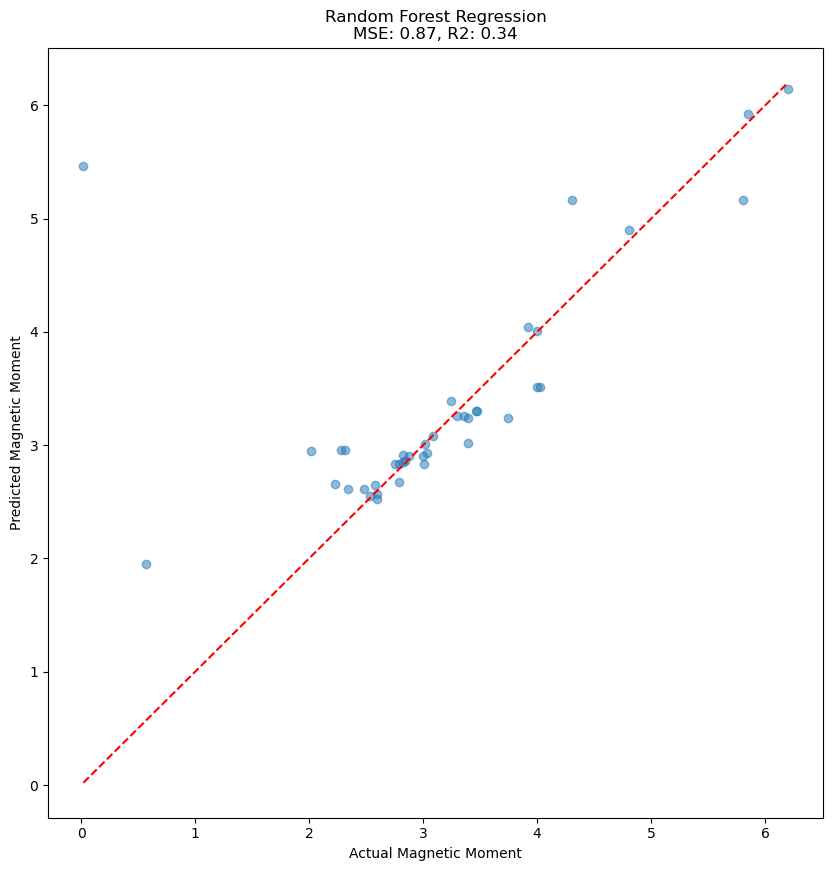

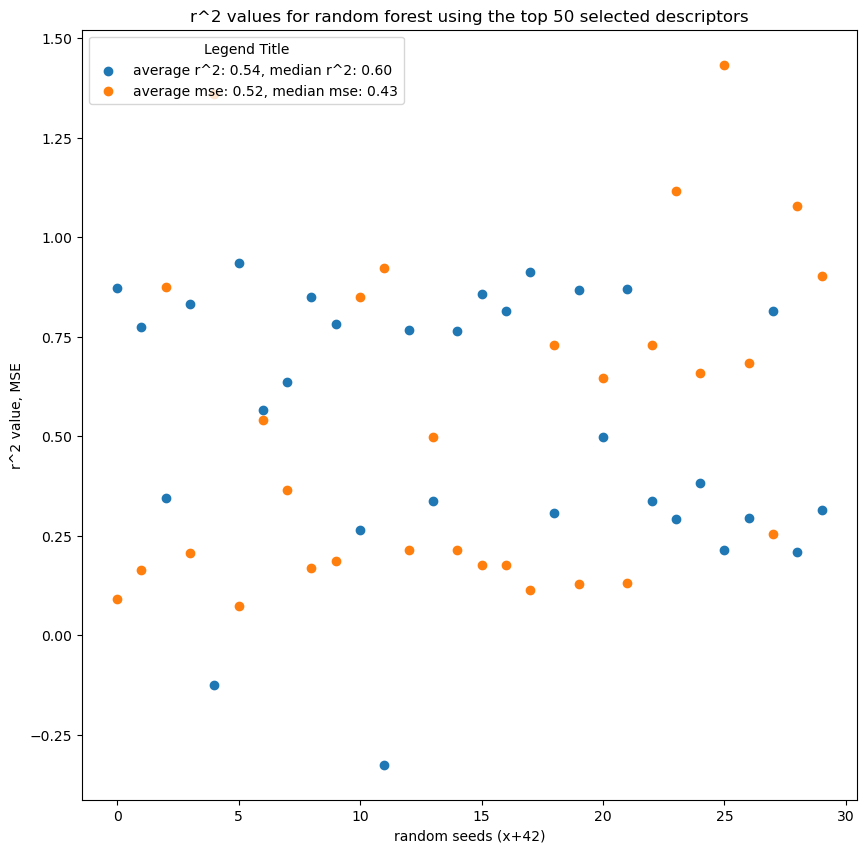

In [22]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor

# target_column_index = df4.columns.get_loc("atomic_radA1")
# X = df4.iloc[:, target_column_index:]
# y = df4['magnetic_moment']
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize the Random Forest Regressor
# rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# # Train the Random Forest Regressor
# rf_regressor.fit(X_train, y_train)

# # Generate predictions
# y_pred = rf_regressor.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# # Plot the predictions
# plt.figure(figsize=(10, 10))
# plt.scatter(y_test, y_pred, alpha=0.5)
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

# plt.xlabel('Actual Magnetic Moment')
# plt.ylabel('Predicted Magnetic Moment')
# plt.title(f'Random Forest Regression\nMSE: {mse:.2f}, R2: {r2:.2f}')
# plt.show()
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statistics


Xhere = X_selected
print(Xhere.shape)
yhere = df4['magnetic_moment']
# Split the data into training and testing sets
mses = []
r2s = []
xs = [i for i in range(30)]
for i in range(30):
    
    X_train, X_test, y_train, y_test = train_test_split(Xhere, yhere, test_size=0.2, random_state=(42+i))

    # Initialize the Random Forest Regressor
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train the Random Forest Regressor
    rf_regressor.fit(X_train, y_train)

    # Generate predictions
    y_pred = rf_regressor.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mses.append(mse)
    r2s.append(r2)

    if i == 2:
        plt.figure(figsize=(10, 10))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

        plt.xlabel('Actual Magnetic Moment')
        plt.ylabel('Predicted Magnetic Moment')
        plt.title(f'Random Forest Regression\nMSE: {mse:.2f}, R2: {r2:.2f}')
        plt.show()
r2_avg = sum(r2s)/len(r2s)
r2_median = statistics.median(r2s)
mse_avg = sum(mses)/len(mses)
mse_median = statistics.median(mses)
#plot the errors and r2s
plt.figure(figsize=(10, 10))
plt.scatter(xs, r2s, label=f"average r^2: {r2_avg:.2f}, median r^2: {r2_median:.2f}")
plt.scatter(xs, mses, label=f"average mse: {mse_avg:.2f}, median mse: {mse_median:.2f}")
plt.xlabel('random seeds (x+42)')
plt.ylabel('r^2 value, MSE')
plt.title(f'r^2 values for random forest using the top {k} selected descriptors')
plt.legend(loc='upper left', title='Legend Title')
# Plot the predictions

# plt.figure(figsize=(10, 10))
# plt.scatter(y_test, y_pred, alpha=0.5)
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

# plt.xlabel('Actual Magnetic Moment')
# plt.ylabel('Predicted Magnetic Moment')
# plt.title(f'Random Forest Regression\nMSE: {mse:.2f}, R2: {r2:.2f}')
# plt.show()



In [16]:
# Print feature importances
feature_importances = rf_regressor.feature_importances_

# Sort the importances in descending order and get the corresponding feature indices
sorted_indices = np.argsort(feature_importances)[::-1]

# Print the feature names and their importances
for i in sorted_indices:
    print(f"Feature {i}: {X_selected.columns[i]} - Importance: {feature_importances[i]}")
#top_n = 10

# # Get the top N features
# top_features = feature_importance_df.head(top_n)
# plt.figure(figsize=(10, 10))
# plt.bar(top_features['Feature'], top_features['Importance'])
# plt.xlabel('Feature')
# plt.ylabel('Importance')
# plt.title(f'Top {top_n} Feature Importances')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

Feature 12: exp((maxPA1+maxSA2)**2) - Importance: 0.1816029949029223
Feature 1: covalent_radA2-covalent_radX - Importance: 0.11459639145833798
Feature 43: (atomic_radA1+covalent_radX)+(covalent_radA2-covalent_radX) - Importance: 0.11167473059104077
Feature 46: (atomic_radX+covalent_radX)+(covalent_radA2-covalent_radX) - Importance: 0.09461619669444277
Feature 42: (atomic_radA1+atomic_radX)+(covalent_radA2-covalent_radX) - Importance: 0.09158416564176204
Feature 11: exp((maxSA1+maxDA2)**2) - Importance: 0.06727487946790094
Feature 47: (atomic_radB1+atomic_radX)+(covalent_radA2-covalent_radX) - Importance: 0.04905167656460649
Feature 48: (atomic_radB1+covalent_radX)+(covalent_radA2-covalent_radX) - Importance: 0.040403062173860645
Feature 49: (covalent_radB1+atomic_radX)+(covalent_radA2-covalent_radX) - Importance: 0.03716846863486665
Feature 44: (covalent_radA1+covalent_radX)+(atomic_radA2-covalent_radA2) - Importance: 0.034593184597922585
Feature 15: exp((maxDA1+maxSA2)**2) - Importanc

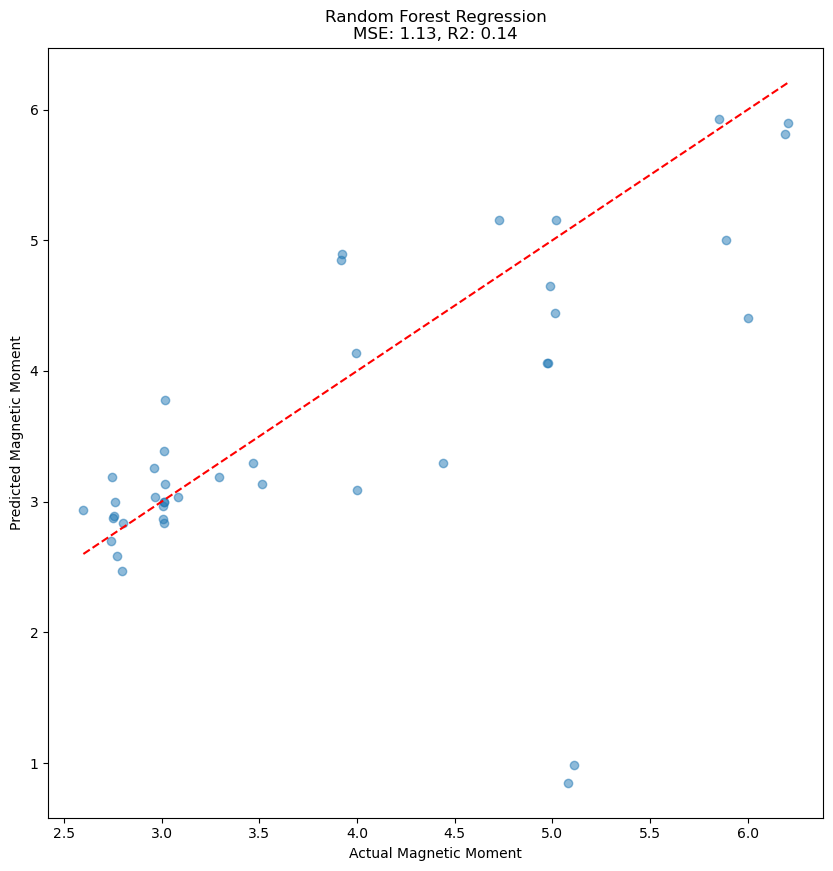

In [17]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.xlabel('Actual Magnetic Moment')
plt.ylabel('Predicted Magnetic Moment')
plt.title(f'Random Forest Regression\nMSE: {mse:.2f}, R2: {r2:.2f}')
plt.show()


In [18]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# import matplotlib.pyplot as plt

# # Assuming you have a dataframe named 'data' and a target column named 'target'
# # Replace 'target' with the actual name of your target column
# target_column_index = df4.columns.get_loc("atomic_radA1")
# X = df4.iloc[:, target_column_index:]
# y = df4['magnetic_moment']
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create a Random Forest classifier
# #rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
# lasso_regressor = Lasso(alpha=.001, random_state=42)

# # Fit the classifier on the training data
# lasso_regressor.fit(X_train, y_train)

# # Get feature importances
# feature_importances = lasso_regressor.coef_

# # Create a dataframe to store feature importances
# feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# # Sort the dataframe by importance in descending order
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# # Specify the number of top features you want to display
# top_n = 40

# # Get the top N features
# top_features = feature_importance_df.head(top_n)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

# Assuming you have a dataframe named 'data' and a target column named 'target'
# Replace 'target' with the actual name of your target column
target_column_index = df4.columns.get_loc("atomic_radA1")
X = df4.iloc[:, target_column_index:]
y = df4['magnetic_moment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate the Mutual Information (MI) scores for each feature
mi_scores = mutual_info_regression(X_train, y_train)

# Create a dataframe to store MI scores
mi_df = pd.DataFrame({'Feature': X.columns, 'MI': mi_scores})

# Sort the dataframe by MI score in descending order
mi_df = mi_df.sort_values(by='MI', ascending=False)

# Specify the number of top features you want to select
top_n = 40

# Get the top N features based on MI scores
top_features = mi_df.head(top_n)



KeyboardInterrupt: 

In [ ]:
top_n1 = 40

# Get the top N features
top_features1 = mi_df.head(top_n1)

Xhere = X[top_features1["Feature"]]
yhere = y

best_feature = None
best_score = float('inf')  # Initialize with a high value
best_r2 = 0
for feature in Xhere.columns:
    X_feature = Xhere[[feature]]  # Select only the current feature
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_feature, y, test_size=0.2, random_state=42)
    
    # Create and fit a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    if mse < best_score:
        best_score = mse
        best_r2 = r2
        best_feature = feature

best_feature_data = Xhere[[best_feature]]
X_train, X_test, y_train, y_test = train_test_split(best_feature_data, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.figure(figsize=(8, 8))
# plt.scatter(X_test, y_test, color='blue', label='Actual')
# plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted')
plt.scatter(y_test, y_pred, color='blue', linewidth=2, label='Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.xlabel(best_feature)
plt.ylabel('Target')
plt.title(f'Linear Regression: {best_feature}')
plt.text(0.1, 0.9, f'MSE: {best_score:.2f}\nR²: {best_r2:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.legend()
plt.show()



NameError: name 'LinearRegression' is not defined

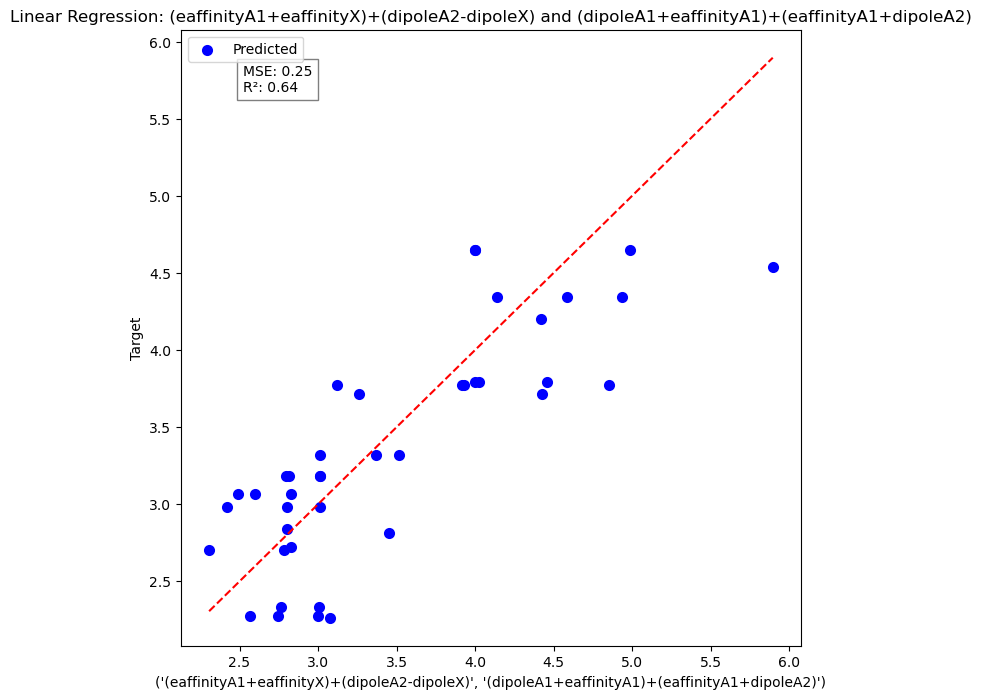

In [ ]:
from itertools import combinations

best_features = None
best_score = float('inf')
best_r2 = 0

for feature_pair in combinations(Xhere.columns, 2):
    X_features = Xhere[list(feature_pair)]
    
    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    if mse < best_score:
        best_score = mse
        best_r2 = r2
        best_features = feature_pair

best_feature_data = Xhere[list(best_features)]
X_train, X_test, y_train, y_test = train_test_split(best_feature_data, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.figure(figsize=(8, 8))
# plt.scatter(X_test.iloc[:, 0], y_test, color='blue', label='Actual')
# plt.scatter(X_test.iloc[:, 0], y_pred, color='red', marker='x', label='Predicted')
plt.scatter(y_test, y_pred, color='blue', linewidth=2, label='Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
str1 = best_features[0], best_features[1]
plt.xlabel(str1)
plt.ylabel('Target')
plt.title(f'Linear Regression: {best_features[0]} and {best_features[1]}')
plt.text(0.1, 0.9, f'MSE: {best_score:.2f}\nR²: {best_r2:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.legend()
plt.show()


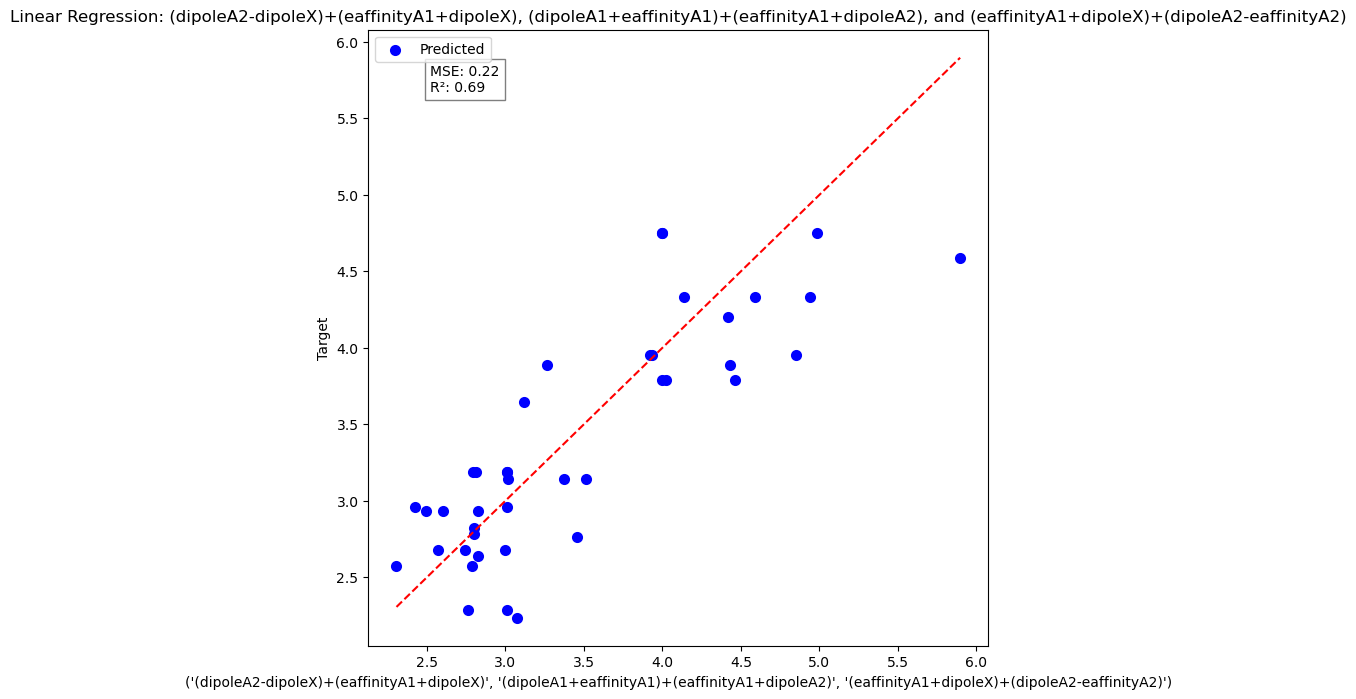

In [ ]:
from itertools import combinations

best_features = None
best_score = float('inf')
best_r2 = 0

for feature_trip in combinations(Xhere.columns, 3):
    X_features = Xhere[list(feature_trip)]
    
    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    if mse < best_score:
        best_score = mse
        best_r2 = r2
        best_features = feature_trip

best_feature_data = Xhere[list(best_features)]
X_train, X_test, y_train, y_test = train_test_split(best_feature_data, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.figure(figsize=(8, 8))
# plt.scatter(X_test.iloc[:, 0], y_test, color='blue', label='Actual')
# plt.scatter(X_test.iloc[:, 0], y_pred, color='red', marker='x', label='Predicted')
plt.scatter(y_test, y_pred, color='blue', linewidth=2, label='Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
str1 = best_features[0], best_features[1], best_features[2]
plt.xlabel(str1)
plt.ylabel('Target')
plt.title(f'Linear Regression: {best_features[0]}, {best_features[1]}, and {best_features[2]}')
plt.text(0.1, 0.9, f'MSE: {best_score:.2f}\nR²: {best_r2:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.legend()
plt.show()


In [ ]:
# Subset the training and testing data using the top N features
#print(X_train.iloc[0])
#print(top_features.iloc[0]["Feature"])
top_n1 = 40

# Get the top N features
top_features1 = mi_df.head(top_n1)
#top_features = feature_importance_df.head(10)
X_train_top = X_train[top_features1["Feature"]]
X_test_top = X_test[top_features1["Feature"]]
#print(X_train_top.iloc[0])
# Create a Random Forest regressor using the top N features
rf_regressor = RandomForestRegressor(random_state=42)

# Fit the regressor on the training data
rf_regressor.fit(X_train_top, y_train)

# Make predictions on the test data
y_pred = rf_regressor.predict(X_test_top)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)

# Print R-squared score
print(f'R-squared score: {r2}')

# # Plot actual vs. predicted values
# plt.figure(figsize=(8, 6))
# plt.scatter(y_test, y_pred)
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.title('Actual vs. Predicted Values')
# plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.xlabel('Actual Magnetic Moment')
plt.ylabel('Predicted Magnetic Moment')
plt.title(f'Random Forest Regression top 10 descriptors\nMSE: {mse:.2f}, R2: {r2:.2f}')
plt.show()


NameError: name 'mi_df' is not defined

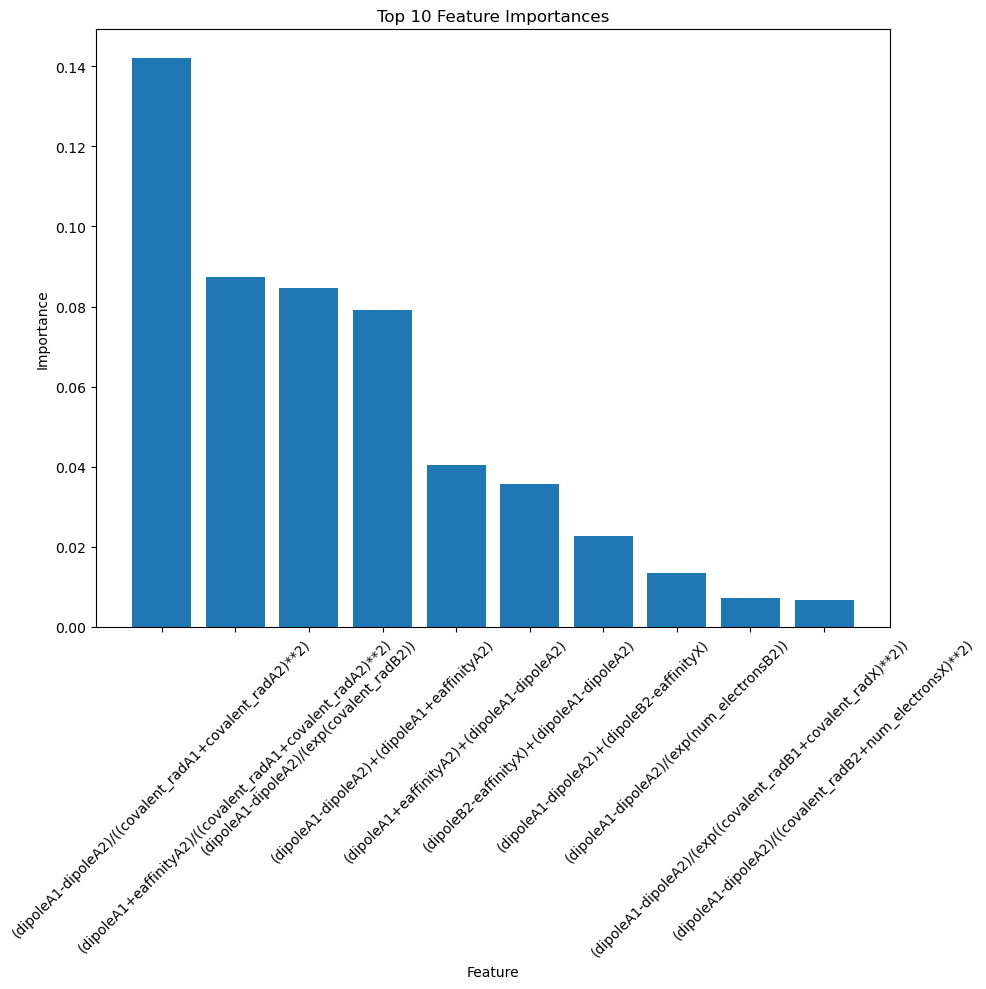

In [ ]:

top_n = 10

# Get the top N features
top_features = feature_importance_df.head(top_n)
plt.figure(figsize=(10, 10))
plt.bar(top_features['Feature'], top_features['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title(f'Top {top_n} Feature Importances')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
tmp = feature_importance_df.head(top_n)
for i in range(10):
    print( "Feature ", i+1, "'s name: ", tmp['Feature'].iloc[i], sep='')

Feature 1's name: (dipoleA1-dipoleA2)/((covalent_radA1+covalent_radA2)**2)
Feature 2's name: (dipoleA1+eaffinityA2)/((covalent_radA1+covalent_radA2)**2)
Feature 3's name: (dipoleA1-dipoleA2)/(exp(covalent_radB2))
Feature 4's name: (dipoleA1-dipoleA2)+(dipoleA1+eaffinityA2)
Feature 5's name: (dipoleA1+eaffinityA2)+(dipoleA1-dipoleA2)
Feature 6's name: (dipoleB2-eaffinityX)+(dipoleA1-dipoleA2)
Feature 7's name: (dipoleA1-dipoleA2)+(dipoleB2-eaffinityX)
Feature 8's name: (dipoleA1-dipoleA2)/(exp(num_electronsB2))
Feature 9's name: (dipoleA1-dipoleA2)/(exp((covalent_radB1+covalent_radX)**2))
Feature 10's name: (dipoleA1-dipoleA2)/((covalent_radB2+num_electronsX)**2)
